In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import tqdm
import warnings
warnings.filterwarnings('ignore')

### Import datasets

In [2]:
#bulk fluorescence data
fluo_raw_1 = pd.read_csv('datasets/bulk_fluo_plate_1.csv', index_col=0)
fluo_raw_2 = pd.read_csv('datasets/bulk_fluo_plate_2.csv', index_col=0)
#od only data
od_raw_1 = pd.read_csv('datasets/od_plate_1.csv', index_col=0)
od_raw_2 = pd.read_csv('datasets/od_plate_2.csv', index_col=0)

In [3]:
incorrect = ['e16x30MjaKlbA', 'e26x30TerThyXS1', 'e34x30TvoVMA', 'e38x32NrdA2', 'e42x30MjaKlbA', 'e33',
            'e34x30SspGyrB.1', 'e38x30SspGyrB.1', 'e16x32gp418.1', 'e22x30gp418', 'e20x30MjaKlbA',
            'e17x32NrdA2.1', 'e34x33NrdA2.1', 'gfp_med_1', 'gfp_med_2', 'gfp_low', 'gfp_low_1', 'gfp_low_2',
            'e15', 'e17', 'e20', 'e26']
fluo = pd.concat([fluo_raw_1, fluo_raw_2], axis=1)
fluo = fluo.drop(incorrect, axis=1)
fluo = fluo.rename(columns={'e22x30gp418.1': 'e22x30gp418', 'e20x30MjaKlbA.1': 'e20x30MjaKlbA'})
od = pd.concat([od_raw_1, od_raw_2], axis=1)
od = od.drop(incorrect, axis=1)
od = od.rename(columns={'e22x30gp418.1': 'e22x30gp418', 'e20x30MjaKlbA.1': 'e20x30MjaKlbA'})

In [4]:
gfp_fluo_1 = fluo_raw_1['gfp_med_1']
gfp_fluo_2 = fluo_raw_2['gfp_med_1']
gfp_od_1 = od_raw_1['gfp_med_1']
gfp_od_2 = od_raw_2['gfp_med_1']

### Select gates by manual inspection

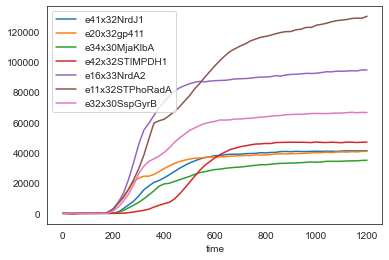

In [19]:
selected = ['e41x32NrdJ1', 'e20x32gp411', 'e34x30MjaKlbA', 'e42x32STIMPDH1',
           'e16x33NrdA2', 'e11x32STPhoRadA', 'e32x30SspGyrB']
fluo_selected = fluo[selected]
od_selected = od[selected]
fluo_selected.plot()
plt.show()

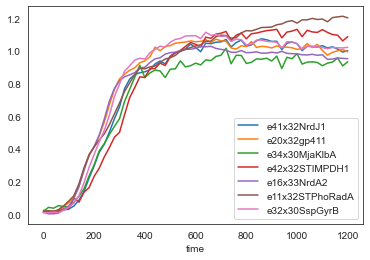

In [20]:
od_selected.plot()
plt.show()

In [21]:
num_traces = fluo_selected.shape[1]
num_traces

7

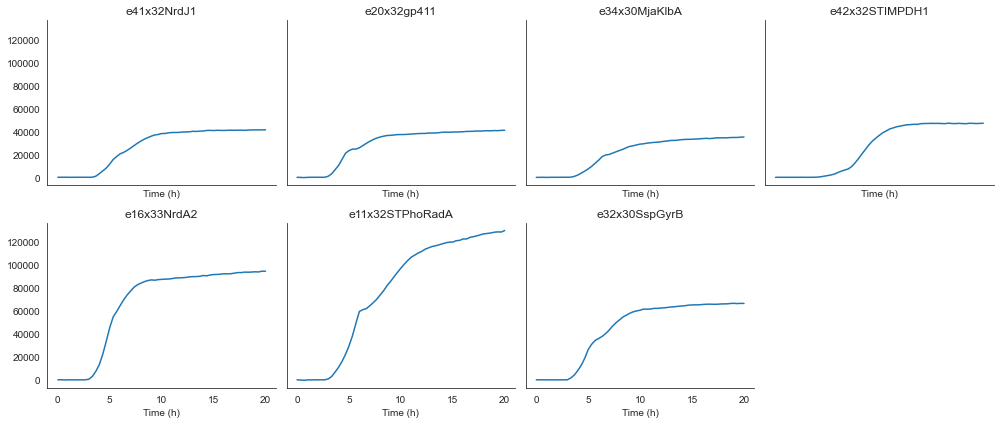

In [22]:
def plot_all(data, num_row, num_col):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < num_traces:
            ax.plot(data.index/60, data.iloc[:, i])
            ax.set_title(data.columns[i])
            #plt.xticks(rotation=90)
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_all(fluo_selected, 2, 4)

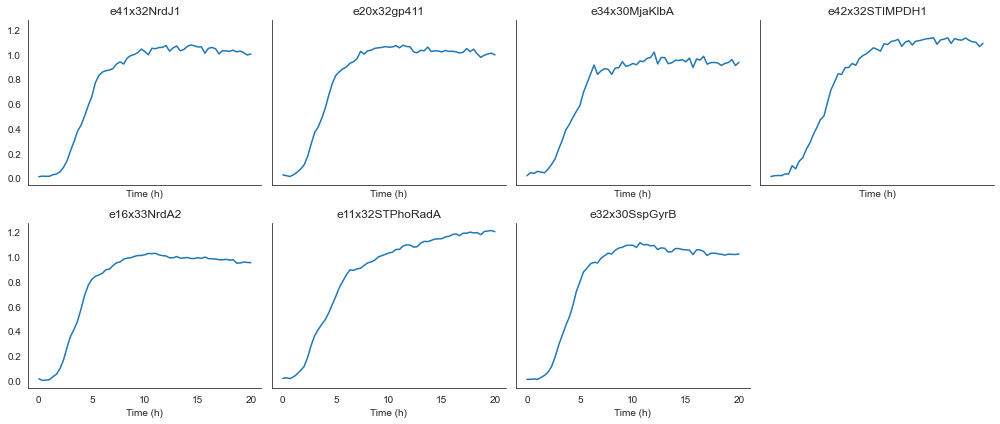

In [23]:
plot_all(od_selected, 2, 4)

## Modeling OD

Changes:
- Also fitting the initial density $c_0$. Without this, the shape isn't quite right.
- Using the real time values, instead of np.arange

In [24]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

### Functions for 1st level inference (fitting growth data) ###
def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

In [25]:
od_bounds = [(0, 0, 0), (1, 2, 0.1)]
od_params_selected = []
od_t = od_selected.index
for idx in range(num_traces):
    od_data = od_selected[od_selected.columns[idx]]
    opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
    od_params_selected.append(opt)

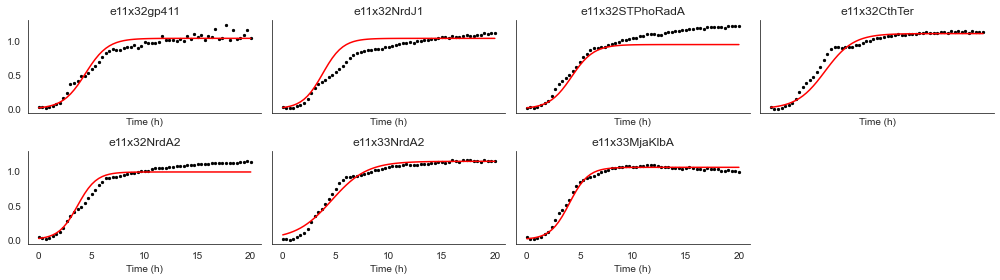

In [26]:
num_col = 4
num_row = 2
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        r, K, c0 = od_params_selected[i]
        ax.scatter(od_t / 60, od.iloc[:, i], c='k', s=5)
        ax.plot(od_t / 60, od_wrapper(od_t, r, K, c0), c='r')
        ax.set_title(od.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

### Define inference helper and fixed functions

In [27]:
def compare_model_data(f_t, f_data, f_sim, ax):
    ax.scatter(f_t / 60, f_data, c='r', s=10)
    ax.plot(f_t / 60, f_sim, c='k')
    ax.set_xlabel('Time (h)')
    
def plot_parameters(f_df, bounds):
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(12, 1.5*(n_paras+1)))
    for i, ax in enumerate(axs):
        ax.errorbar(fluo_selected.columns, values[:,i], errors[:,i], fmt='.')
        #ax.set_ylim(bounds[0][i], bounds[1][i])
        ax.set_ylabel(parameters[i])
    plt.xticks(rotation=90)
    sns.despine()
    
def plot_comparisons(f_sim, f_data):
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(14, 4))
    axr = axs.ravel()

    for i, ax in enumerate(axr):
        if i < num_traces:
            ax = axr[i]
            compare_model_data(f_t, f_data[i], f_sim[i], ax)
            ax.set_title(fluo_selected.columns[i])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()

## Modelling fluorescence

The limitation of this model is that it assumes the GFP degrades, but it is supposed to be negligble. Can we assume that the degradation rate here is the resource limitation?

In [28]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper(t, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = syn_ECFn - (deg + gamma) * ECFn
        dECFc = syn_ECFc - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

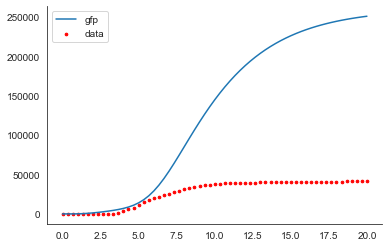

In [29]:
def plot_model(idx, fluo=fluo_selected, od_params=od_params_selected, show_data=True, show_all=False):

    f_data = fluo.iloc[:,idx]
    f_t = fluo.index
    alpha, beta, c0 = od_params[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, extra, y0)
        return fit
    
    model = model_fit(f_t, 1, 1, 0.000005, 0.010594, 1187.391794, 0.004312, 1.0, 2.000000)
    ecfn = pd.Series(model[0], index=f_t/60)
    ecfc = pd.Series(model[1], index=f_t/60)
    ecf = pd.Series(model[2], index=f_t/60)
    gfp = pd.Series(model[3], index=f_t/60)
    od = pd.Series(model[4], index=f_t/60)

    if show_data:
        plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
    if show_all:
        sns.lineplot(ecfn, label='ecfn')
        sns.lineplot(ecf, label='ecf')
        sns.lineplot(od, label='od')
    plt.plot(gfp, label='gfp')
    plt.legend()
    sns.despine()
    plt.show()
    
plot_model(0)

[3.49222058e+00 3.71564938e+00 3.23826764e-07 1.02465159e-05
 3.65145688e+02 8.88510834e-03 1.62878098e+00 2.00000000e+00]


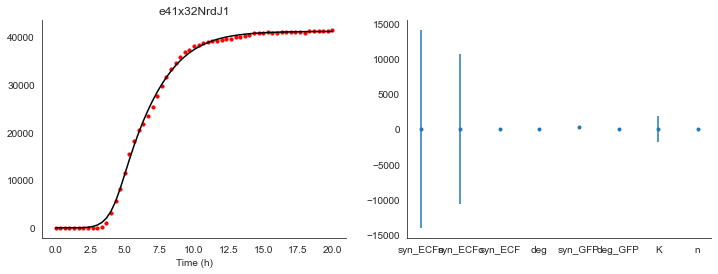

In [30]:
def fit_deg_stable_gfp(idx):
    
    f_data = fluo_selected.iloc[:,idx]
    f_t = fluo_selected.index
    title = fluo_selected.columns[idx]
    alpha, beta, c0 = od_params_selected[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    
    parameters = ['syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    init_guess = [1, 1, 1e-6, 1e-3, 1e2, 1e-2, 1, 2]
    gate_bounds_together = [np.array(init_guess)*0, np.array(init_guess)*100]
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, 4, extra, y0)
        return fit[3]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    print(f_params)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

idx = 0
f_df, f_sim, f_data = fit_deg_stable_gfp(idx)
f_t = f_data.index
f, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(fluo_selected.columns[idx])
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

In [31]:
f_df_deg, f_sim_deg, f_data_deg = zip(*[fit_deg_stable_gfp(idx) for idx in tqdm.trange(len(od_params_selected))])

 14%|█▍        | 1/7 [00:01<00:11,  1.85s/it]

[3.49222058e+00 3.71564938e+00 3.23826764e-07 1.02465159e-05
 3.65145688e+02 8.88510834e-03 1.62878098e+00 2.00000000e+00]


 29%|██▊       | 2/7 [00:08<00:22,  4.45s/it]

[3.57877405e+00 2.82144681e+00 7.28180433e-07 6.53119119e-06
 4.74199113e+02 1.20901634e-02 1.77252299e+00 2.00000000e+00]


 43%|████▎     | 3/7 [00:09<00:12,  3.02s/it]

[2.96829320e+00 3.07155491e+00 3.05572496e-07 7.31578646e-05
 2.25878331e+02 6.61782999e-03 1.06550474e+00 2.00000000e+00]


 57%|█████▋    | 4/7 [00:12<00:08,  2.87s/it]

[5.17356718e-01 4.68566742e-01 7.62650090e-06 6.25644391e-03
 5.00905816e+02 1.05357957e-02 1.01572095e+00 2.00000000e+00]


 71%|███████▏  | 5/7 [00:13<00:04,  2.39s/it]

[7.19163172e+00 2.84736932e+00 1.98861617e-06 8.11097875e-07
 1.19526934e+03 1.30622425e-02 1.19034724e+01 2.00000000e+00]


 86%|████████▌ | 6/7 [00:14<00:01,  1.89s/it]

[5.51478734e+00 6.83660917e+00 4.77179925e-08 3.47682293e-04
 6.66041048e+02 5.08540309e-03 1.26804218e+00 2.00000000e+00]


100%|██████████| 7/7 [00:15<00:00,  2.25s/it]

[5.23794287e+00 6.11176342e+00 1.27637180e-07 2.79862903e-07
 5.19979126e+02 7.88895029e-03 8.83880921e-01 2.00000000e+00]


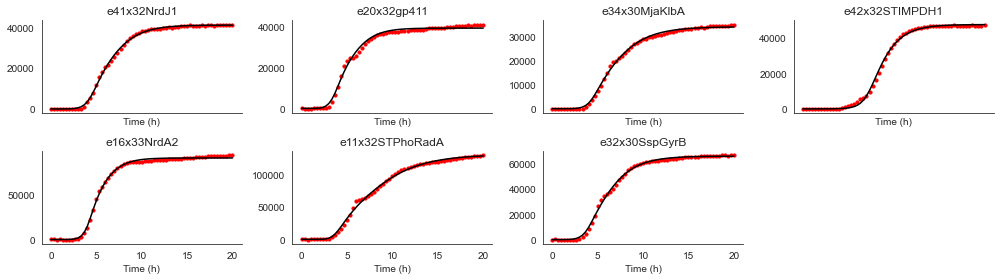

In [32]:
plot_comparisons(f_sim_deg, f_data_deg)

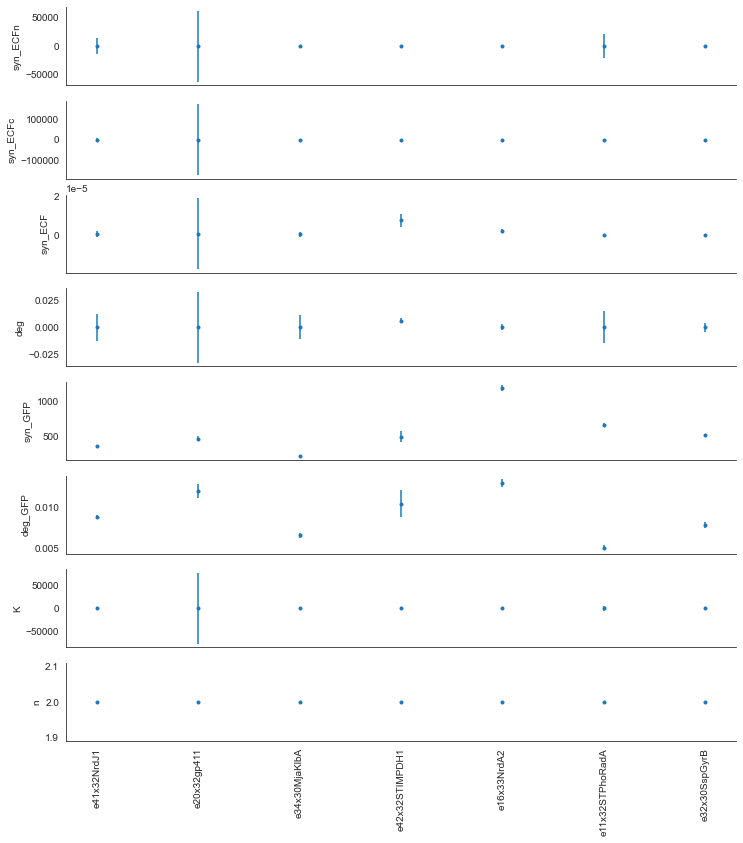

In [33]:
init_guess = [1e-6, 1e-3, 1e2, 1e-2, 2]
gate_bounds = [np.array(init_guess)*0, np.array(init_guess)*100]
plot_parameters(f_df_deg, gate_bounds)

### Layering the Models

In [34]:
class Gate:
    def __init__(self, name, gate_params, od_params, fluo_data, od_data):
        
        #metadata
        self.name = name
        
        #parameters
        self.syn_ECFn = gate_params[0]
        self.syn_ECFc = gate_params[1]
        self.syn_ECF = gate_params[2]
        self.deg = gate_params[3]
        self.syn_GFP = gate_params[4]
        self.deg_GFP = gate_params[5]
        self.K = gate_params[6]
        self.n = gate_params[7]
        self.alpha = od_params[0]
        self.beta = od_params[1]
        self.gamma = 0
        
        #initial states
        self.ECFn = 0
        self.ECFc = 0
        self.ECF = 0
        self.GFP = 0
        self.OD = od_params[2]
        
        #derivative states
        self.dECFn = 0
        self.dECFc = 0
        self.dECF = 0
        self.dGFP = 0
        self.dOD = 0
        
        #connection
        self.connection = None
        
        #data
        self.fluo_data = fluo_data
        self.od_data = od_data
        
    def get_params(self):
        return [self.syn_ECFn, self.syn_ECFc, self.syn_ECF, self.deg, self.syn_GFP, self.deg_GFP, self.K, self.n, self.alpha, self.beta]
    
    def get_init_states(self):
        return [self.ECFn, self.ECFc, self.ECF, self.GFP, self.OD]
    
class Connection:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        self.name = name
        self.input1 = input1
        self.input2 = input2
        self.output = output
        self.level = level #0: input, 1: intermediate, 2:output
        self.index = index
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit:
    def __init__(self, fluo, od, gate_params, od_params, schema, arrangement):
        
        #inducers
        self.inducers = [1] * 8
        
        #gate
        self.gates = []
        for i in arrangement:
            self.gates.append(Gate('g' + str(i), gate_params[i], od_params[i], fluo.iloc[:,i], od.iloc[:,i]))
        
        self.connections = [
            Connection('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4),
            Connection('c2', self.inducers[2], self.inducers[3], None, 0, 1, 2, 3, 4),
            Connection('c3', self.inducers[4], self.inducers[5], None, 0, 4, 0, 1, 6),
            Connection('c4', self.inducers[6], self.inducers[7], None, 0, 3, 6, 7, 5),
            Connection('c5', self.gates[0], self.gates[1], None, 1, 4, 0, 1, 6),
            Connection('c6', self.gates[2], self.gates[3], None, 1, 5, 2, 3, 6),
            Connection('c7', self.gates[4], self.gates[5], None, 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)

[2 0 5 4 3 6 1]
39210.35634297284


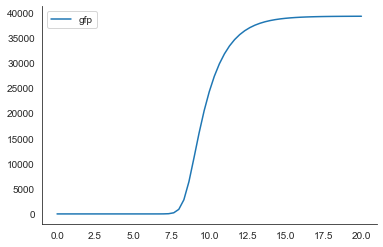

In [35]:
def hill_equation2(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper2(t, circuit):
    
    y0 = np.array([g.get_init_states() for g in circuit.gates]).ravel()
    
    def gate_model2(y, t):
        
        yi = np.reshape(y, (-1, 5))
        yn = []
        
        for i, g in enumerate(circuit.gates):
            
            g.ECFn, g.ECFc, g.ECF, g.GFP, g.OD = yi[i]
        
            #growth
            g.gamma = growth_rate(t, g.OD, g.alpha, g.beta)
            g.dOD = g.gamma * g.OD
            
            #level 0 (input)
            if g.connection.level==0:
                
                g.dECFn = g.syn_ECFn * g.connection.input1 - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * g.connection.input2 - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 1 (middle)
            elif g.connection.level==1:

                input1 = g.connection.input1
                input2 = g.connection.input2
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 2 (output)
            elif g.connection.level==2:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
        
        return np.array(yn).ravel()
    
    solution = odeint(gate_model2, y0, t)
    return solution.transpose()


gate_params_selected = [par['Value'] for par in f_df_deg]
arrangement = np.arange(len(gate_params_selected))
np.random.shuffle(arrangement)
print(arrangement)

circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arrangement)

f_t = fluo_selected.index

model = gate_wrapper2(f_t, circuit)
gfp = pd.Series(model[33], index=f_t/60)
print(gfp.max()-gfp.min())
plt.plot(gfp, label='gfp')
plt.legend()
sns.despine()
plt.show()

In [36]:
#model
def hill_equation3(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper3(t,
                  syn_ECFn1, syn_ECFc1, syn_ECF1, deg1, syn_GFP1, deg_GFP1, K1, n1, extra1,
                  syn_ECFn2, syn_ECFc2, syn_ECF2, deg2, syn_GFP2, deg_GFP2, K2, n2, extra2,
                  syn_ECFn3, syn_ECFc3, syn_ECF3, deg3, syn_GFP3, deg_GFP3, K3, n3, extra3,
                  y0):
    
    #fixed parameters
    alpha1, beta1 = extra1
    alpha2, beta2 = extra2
    alpha3, beta3 = extra3

    def gate_model3(y, t):
        
        #dependent variables
        [ECFn1, ECFc1, ECF1, GFP1, OD1, ECFn2, ECFc2, ECF2, GFP2, OD2, ECFn3, ECFc3, ECF3, GFP3, OD3] = y
        
        gamma1 = growth_rate(t, OD1, alpha1, beta1)
        #differential equations
        dOD1 = gamma1 * OD1
        dECFn1 = syn_ECFn1 - (deg1 + gamma1) * ECFn1
        dECFc1 = syn_ECFc1 - (deg1 + gamma1) * ECFc1
        dECF1 = syn_ECF1 * ECFn1 * ECFc1 - (deg1 + gamma1) * ECF1
        
        dGFP1 = 0.0
        #dGFP1 = syn_GFP1 * hill_equation3(ECF1, K1, n1) - (deg_GFP1 + gamma1) * GFP1
        
        
        gamma2 = growth_rate(t, OD2, alpha2, beta2)
        #differential equations
        dOD2 = gamma2 * OD2
        dECFn2 = syn_ECFn2 - (deg2 + gamma2) * ECFn2
        dECFc2 = syn_ECFc2 - (deg2 + gamma2) * ECFc2
        dECF2 = syn_ECF2 * ECFn2 * ECFc2 - (deg2 + gamma2) * ECF2
        
        dGFP2 = 0.0
        #dGFP2 = syn_GFP2 * hill_equation3(ECF2, K2, n2) - (deg_GFP2 + gamma2) * GFP2
        
        
        gamma3 = growth_rate(t, OD3, alpha3, beta3)
        #differential equations
        dOD3 = gamma3 * OD3
        dECFn3 = syn_ECFn3 * hill_equation3(ECF1, K1, n1) - (deg3 + gamma3) * ECFn3
        dECFc3 = syn_ECFc3 * hill_equation3(ECF2, K2, n2) - (deg3 + gamma3) * ECFc3
        dECF3 = syn_ECF3 * ECFn3 * ECFc3 - (deg3 + gamma3) * ECF3
        
        dGFP3 = syn_GFP3 * hill_equation3(ECF3, K3, n3) - (deg_GFP3 + gamma3) * GFP3

        return [dECFn1, dECFc1, dECF1, dGFP1, dOD1, dECFn2, dECFc2, dECF2, dGFP2, dOD2, dECFn3, dECFc3, dECF3, dGFP3, dOD3]
    
    solution = odeint(gate_model3, y0, t)
    return solution.transpose()

(0.015614765304449049, 1.0298354765598425)
(0.01745928700466915, 1.02938098438527)
(0.015952472421331923, 0.938916150089576)


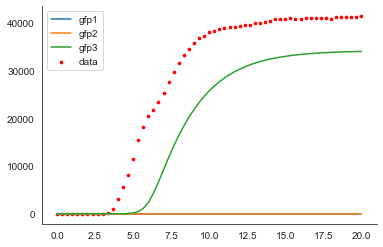

In [37]:
def plot_model3(idx1, idx2, idx3, fluo=fluo_selected, od_params=od_params_selected, show_data=True, show_all=False):

    f_data = fluo.iloc[:,idx1]
    f_t = fluo.index
    
    alpha1, beta1, c01 = od_params[idx1]
    y01 = [0, 0, 0, 0, c01]
    extra1 = (alpha1, beta1)
    print(extra1)
    params1 = gate_params_selected[idx1]
    
    alpha2, beta2, c02 = od_params[idx2]
    y02 = [0, 0, 0, 0, c02]
    extra2 = (alpha2, beta2)
    print(extra2)
    params2 = gate_params_selected[idx2]
    
    alpha3, beta3, c03 = od_params[idx3]
    y03 = [0, 0, 0, 0, c03]
    extra3 = (alpha3, beta3)
    print(extra3)
    params3 = gate_params_selected[idx3]
    
    y0 = y01 + y02 + y03
    
    def model_fit3(t,
                   a1, b1, c1, d1, e1, f1, g1, h1,
                   a2, b2, c2, d2, e2, f2, g2, h2,
                   a3, b3, c3, d3, e3, f3, g3, h3):
        fit = gate_wrapper3(t, \
                   a1, b1, c1, d1, e1, f1, g1, h1, extra1, \
                   a2, b2, c2, d2, e2, f2, g2, h2, extra2, \
                   a3, b3, c3, d3, e3, f3, g3, h3, extra3, y0)
        return fit
    
    model = model_fit3(f_t, *params1, *params2, *params3)
    gfp1 = pd.Series(model[3], index=f_t/60)
    gfp2 = pd.Series(model[8], index=f_t/60)
    gfp3 = pd.Series(model[13], index=f_t/60)

    if show_data:
        plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
    plt.plot(gfp1, label='gfp1')
    plt.plot(gfp2, label='gfp2')
    plt.plot(gfp3, label='gfp3')
    plt.legend()
    sns.despine()
    plt.show()
    
plot_model3(0, 1, 2)

### Genetic Algorithm

In [38]:
def initialPopulation(pop_size, length):
    
    population = []
    arrangement = np.arange(length)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement)
    return np.array(population)

pop = initialPopulation(10, 7)
pop

array([[0, 3, 2, 4, 6, 1, 5],
       [3, 1, 2, 4, 5, 6, 0],
       [2, 0, 1, 6, 5, 3, 4],
       [4, 2, 3, 5, 6, 1, 0],
       [2, 1, 6, 5, 3, 0, 4],
       [3, 4, 2, 1, 5, 6, 0],
       [0, 1, 3, 6, 5, 2, 4],
       [0, 4, 6, 3, 1, 2, 5],
       [6, 3, 5, 2, 4, 1, 0],
       [3, 5, 0, 2, 4, 1, 6]])

In [39]:
def calculateFitness(pop):
    
    f_t = fluo_selected.index
    fitness = []
    
    for i, p in enumerate(pop):
        
        circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        model = gate_wrapper2(f_t, circuit)
        gfp = pd.Series(model[33], index=f_t/60)
        fitness.append(gfp.max()-gfp.min())
        
    return np.array(fitness)

fitness = calculateFitness(pop)
fitness

array([126101.24120042,  40971.991415  ,  91487.0008855 ,  41008.27762486,
        91489.48813191,  40969.28561895,  91490.81320962, 125766.29133895,
        41006.97658655,  65679.01171791])

In [40]:
def rankIndiv(population):
    
    fitness = calculateFitness(population)
    
    #fitnessResults = {}
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    #fitnessResults[i] = Fitness(population[i]).routeFitness()
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

popRanked = rankIndiv(pop)
popRanked

array([[array([0, 3, 2, 4, 6, 1, 5]), 126101.24120042441],
       [array([0, 4, 6, 3, 1, 2, 5]), 125766.29133895232],
       [array([0, 1, 3, 6, 5, 2, 4]), 91490.81320962212],
       [array([2, 1, 6, 5, 3, 0, 4]), 91489.48813191241],
       [array([2, 0, 1, 6, 5, 3, 4]), 91487.0008854979],
       [array([3, 5, 0, 2, 4, 1, 6]), 65679.01171790692],
       [array([4, 2, 3, 5, 6, 1, 0]), 41008.277624862414],
       [array([6, 3, 5, 2, 4, 1, 0]), 41006.97658654682],
       [array([3, 1, 2, 4, 5, 6, 0]), 40971.991414995675],
       [array([3, 4, 2, 1, 5, 6, 0]), 40969.28561894605]], dtype=object)

In [41]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

selected = selection(popRanked, 5)
selected

[array([0, 3, 2, 4, 6, 1, 5]),
 array([0, 4, 6, 3, 1, 2, 5]),
 array([0, 1, 3, 6, 5, 2, 4]),
 array([2, 1, 6, 5, 3, 0, 4]),
 array([2, 0, 1, 6, 5, 3, 4]),
 array([2, 0, 1, 6, 5, 3, 4]),
 array([0, 4, 6, 3, 1, 2, 5]),
 array([2, 1, 6, 5, 3, 0, 4]),
 array([0, 1, 3, 6, 5, 2, 4]),
 array([2, 1, 6, 5, 3, 0, 4])]

In [42]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

parents = matingPool(pop, selected)
parents

[array([0, 3, 2, 4, 6, 1, 5]),
 array([0, 4, 6, 3, 1, 2, 5]),
 array([0, 1, 3, 6, 5, 2, 4]),
 array([2, 1, 6, 5, 3, 0, 4]),
 array([2, 0, 1, 6, 5, 3, 4]),
 array([2, 0, 1, 6, 5, 3, 4]),
 array([0, 4, 6, 3, 1, 2, 5]),
 array([2, 1, 6, 5, 3, 0, 4]),
 array([0, 1, 3, 6, 5, 2, 4]),
 array([2, 1, 6, 5, 3, 0, 4])]

In [43]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breedPopulation(matingpool, eliteSize):
    
    children = []
    length = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return np.array(children)

children = breedPopulation(selected, 3)
children

array([[0, 3, 2, 4, 6, 1, 5],
       [0, 4, 6, 3, 1, 2, 5],
       [0, 1, 3, 6, 5, 2, 4],
       [4, 6, 3, 1, 2, 5, 0],
       [3, 0, 2, 1, 6, 5, 4],
       [6, 5, 0, 1, 3, 2, 4],
       [3, 1, 2, 0, 4, 6, 5],
       [2, 1, 6, 5, 3, 0, 4],
       [1, 2, 6, 5, 3, 0, 4],
       [4, 6, 3, 0, 1, 2, 5]])

In [44]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

mutatePopulation(children, 0.01)

array([[0, 3, 2, 4, 6, 1, 5],
       [0, 4, 6, 3, 1, 2, 5],
       [0, 1, 3, 6, 5, 2, 4],
       [4, 6, 3, 1, 2, 5, 0],
       [3, 0, 2, 1, 6, 5, 4],
       [2, 5, 0, 1, 3, 6, 4],
       [3, 1, 2, 0, 4, 6, 5],
       [2, 1, 6, 5, 3, 0, 4],
       [1, 2, 6, 5, 3, 0, 4],
       [4, 6, 3, 0, 1, 2, 5]])

In [45]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, 7)
    pop_copy = [i for i in pop]
    print(len(pop))
    #print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        print(i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    #print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    #bestRouteIndex = rankIndiv(pop)[0][0]
    #bestRoute = pop[bestRouteIndex]
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=5, mutationRate=0.01, generations=20)
result

100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


array([[array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([0, 2, 3, 1, 4, 6, 5]), 126147.51205334689],
       [array([3, 1, 0, 2, 6, 4, 5]), 126147.5120449497],
       [array([2, 0, 3, 1, 4, 6, 5]), 126147.51175387633],
       [array([0, 2, 3, 4, 6, 1, 5]), 126123.22576081402],
       [array([0, 2, 3, 6, 4, 1, 5]), 126113.41383000543],
       [array([1, 0, 3, 2, 4, 6, 5]), 126111.57888484158],
       [array([1, 0, 3, 2, 4, 6, 5]), 126111.57888484158],
       [array([1, 0, 2, 3, 4, 6, 5]), 126111.57888484152],
       [array([1, 0, 2, 3, 4, 6, 5]), 126111.57888484152],
       [array([1, 0, 2, 3, 4, 6, 5]), 126111.57888484152],
       [array([4, 0, 2, 3, 1, 6, 5]), 126107.5718024619],

[0 2 3 1 4 6 5]
126147.51205334689


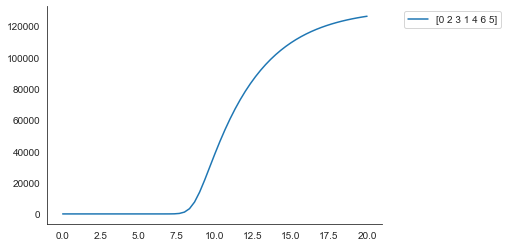

In [50]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

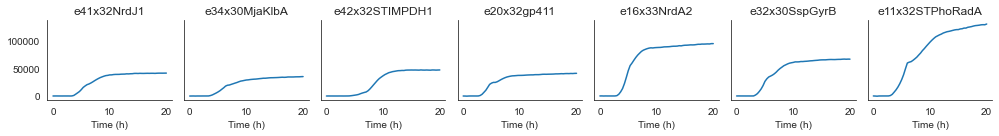

In [51]:
final_asg = fluo_selected[['e41x32NrdJ1', 'e34x30MjaKlbA', 'e42x32STIMPDH1', 'e20x32gp411', 
           'e16x33NrdA2', 'e32x30SspGyrB', 'e11x32STPhoRadA']]
num_col = 7
num_row = 1
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        ax.plot(od_t / 60, final_asg.iloc[:, i])
        ax.set_title(final_asg.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [47]:
def geneticAlgorithmPlot(pop_copy, popSize, eliteSize, mutationRate, generations):
    pop = [i for i in pop_copy]
    
    progress = []
    progress.append(rankIndiv(pop)[0][1])
    
    for i in range(0, generations):
        print(i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(rankIndiv(pop)[0][1])
    
    return progress
    
progress = geneticAlgorithmPlot(pop_copy, popSize=100, eliteSize=20, mutationRate=0.01, generations=50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

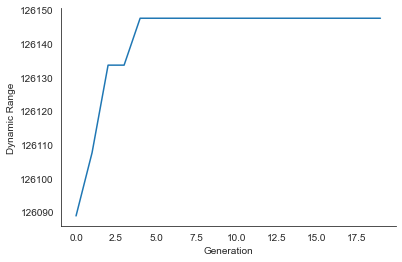

In [48]:
plt.figure(figsize=[6, 4])
plt.plot(progress[:20])
plt.ylabel('Dynamic Range')
plt.xlabel('Generation')
sns.despine()
plt.show()